# Wendling Network Examples

Subnetwork (3 nodes), medium (20 nodes), and larger (86 nodes) Wendling simulations using the new network API. A lightweight fMRI-style demo shows how to convolve LFP with an HRF for illustrative BOLD-like signals.

Prereqs:
- `conda activate brainpy_model`
- `pip install -r requirements.txt`

Note: cells are written for quick CPU runs (no JIT). Adjust `duration_ms` and `jit` as needed.

In [27]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Ensure repo src/ is on path (notebooks/exploration is one level deeper)
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root / "src"))

from wendling_sim import simulate
from wendling_sim.features.psd import compute_psd

plt.style.use("seaborn-v0_8")

## Helper: run network and compute PSD

- `network_cfg` supports generator-based graphs (see `connectivity/generators.py`).
- Outputs are time-major: `lfp[t, i]`.
- PSD is computed on the first node for quick inspection; adjust as needed.

In [28]:
def run_network(network_cfg, sim_cfg=None, seed=0):
    sim_cfg = sim_cfg or {"dt_ms": 0.1, "duration_ms": 2000.0, "jit": False}
    res = simulate(
        sim_cfg=sim_cfg,
        model_cfg={},
        network_cfg=network_cfg,
        noise_cfg={"seed": seed},
    )
    lfp = np.asarray(res.lfp)
    fs = 1000.0 / sim_cfg.get("dt_ms", 0.1)
    psd_res = compute_psd(lfp[:, 0], fs=fs, nperseg=4096, freq_range=(1, 50))
    return res, psd_res


def plot_quick(res, psd_res, title_prefix=""):
    lfp = np.asarray(res.lfp)
    t_ms = res.t_s * 1000.0
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sl = slice(len(t_ms)//4, len(t_ms)//4 + int(2000 / (res.meta["dt_s"] * 1000)))
    axes[0].plot(t_ms[sl], lfp[sl, 0])
    axes[0].set_title(f"{title_prefix} LFP (node 0)")
    axes[0].set_xlabel("Time (ms)")
    axes[0].set_ylabel("mV")
    axes[1].semilogy(psd_res.freqs, psd_res.psd)
    axes[1].set_xlim(0, 50)
    axes[1].set_title(f"{title_prefix} PSD (node 0)")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("PSD")
    plt.tight_layout()
    plt.show()

## 3-node subnetwork (ring lattice)
- Generator: `ring_lattice`, k=1
- `G_net=0.5`
- Short 2s run for a quick sanity check.

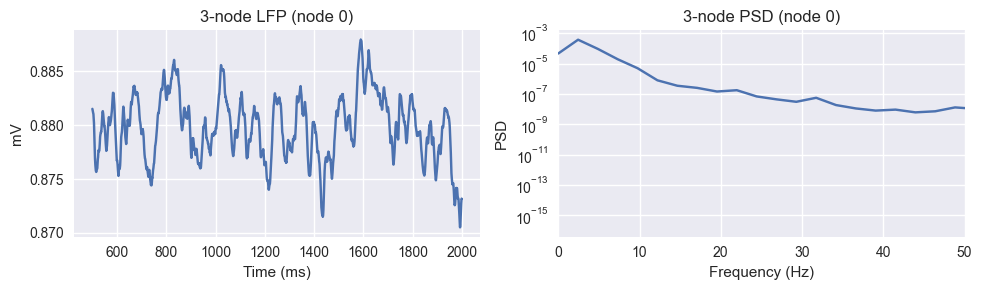

In [29]:
net3 = {
    "n_nodes": 3,
    "generator": {"name": "ring_lattice", "options": {"k": 2, "weight": 1.0, "seed": 1}},
    "G_net": 0.5,
    "normalize": "row_sum",
}
sim3 = {"dt_ms": 0.1, "duration_ms": 2000.0, "jit": True}
res3, psd3 = run_network(net3, sim_cfg=sim3, seed=10)
plot_quick(res3, psd3, title_prefix="3-node")

## 20-node random graph
- Generator: `erdos_renyi`, p=0.2
- `G_net=0.8`, row-sum normalized
- 5s run to observe spectral content.

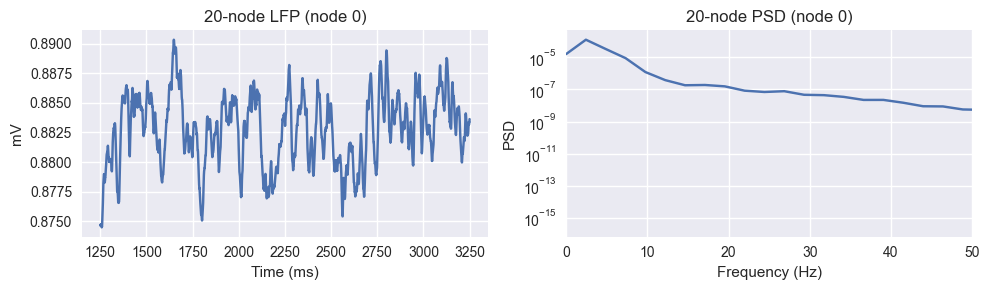

In [30]:
net20 = {
    "n_nodes": 20,
    "generator": {"name": "erdos_renyi", "options": {"p": 0.2, "weight_scale": 0.8, "weight_dist": "lognormal", "seed": 123}},
    "G_net": 0.8,
    "normalize": "row_sum",
}
sim20 = {"dt_ms": 0.1, "duration_ms": 5000.0, "jit": True}
res20, psd20 = run_network(net20, sim_cfg=sim20, seed=20)
plot_quick(res20, psd20, title_prefix="20-node")

## 86-node small-world-like graph
- Generator: `small_world`, k=6, beta=0.1
- `G_net=1.0`
- 5s run; expect heavier coupling and richer spectra.

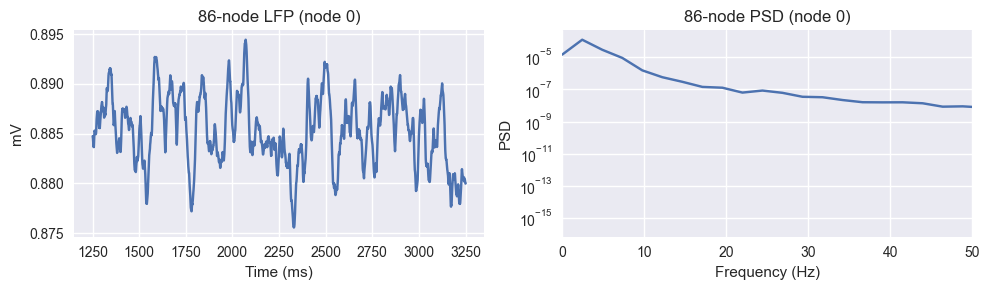

In [31]:
net86 = {
    "n_nodes": 86,
    "generator": {"name": "stochastic_block_model", "options": { "weight_scale": 0.6, "weight_dist": "lognormal", "seed": 86}},
    "G_net": 1.0,
    "normalize": "row_sum",
}
sim86 = {"dt_ms": 0.1, "duration_ms": 5000.0, "jit": True}
res86, psd86 = run_network(net86, sim_cfg=sim86, seed=30)
plot_quick(res86, psd86, title_prefix="86-node")

## fMRI-style toy demo (HRF convolution)

This is a simple illustrative pipeline (not a calibrated biophysical BOLD model):
1. Take the mean LFP across nodes.
2. Downsample to ~200 Hz to match a slower TR-like timescale.
3. Convolve with a double-gamma HRF kernel.
4. Plot the pseudo-BOLD trace.

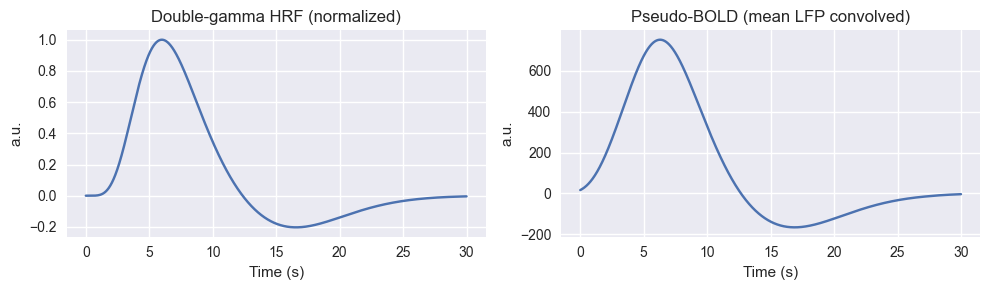

In [32]:
def double_gamma_hrf(t, peak1=6, under=16, p_u_ratio=0.35, scale=1.0):
    import math
    t = np.asarray(t, dtype=float)
    h1 = (t ** peak1) * np.exp(-t) / math.factorial(peak1)
    h2 = (t ** under) * np.exp(-t) / math.factorial(under)
    h = h1 - p_u_ratio * h2
    h = h / (np.max(np.abs(h)) + 1e-9)
    return h * scale


def lfp_to_pseudo_bold(lfp, dt_ms, target_fs=200.0):
    lfp = np.asarray(lfp)
    if lfp.ndim == 2:
        lfp = lfp.mean(axis=1)
    src_fs = 1000.0 / dt_ms
    decim = max(1, int(src_fs / target_fs))
    lfp_ds = lfp[::decim]
    t_h = np.linspace(0, 30, int(30 * target_fs))
    hrf = double_gamma_hrf(t_h)
    bold = np.convolve(lfp_ds, hrf, mode="same")
    t_bold = np.arange(len(bold)) / target_fs
    return t_bold, bold, hrf, target_fs


# Use the 20-node run for BOLD-like demo
t_bold, bold, hrf, bold_fs = lfp_to_pseudo_bold(res20.lfp, dt_ms=sim20["dt_ms"], target_fs=200.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(np.arange(len(hrf)) / bold_fs, hrf)
axes[0].set_title("Double-gamma HRF (normalized)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("a.u.")

axes[1].plot(t_bold, bold)
axes[1].set_title("Pseudo-BOLD (mean LFP convolved)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("a.u.")
plt.tight_layout()
plt.show()

## Notes
- For deterministic comparisons, fix seeds in both `noise_cfg` and generator options.
- For larger networks (86+), consider enabling JIT once shapes are stable.
- The HRF example is illustrative only; swap in your preferred BOLD model as needed.

## Connectivity visualization

Quick check that generated networks are populated (density, sample heatmaps).

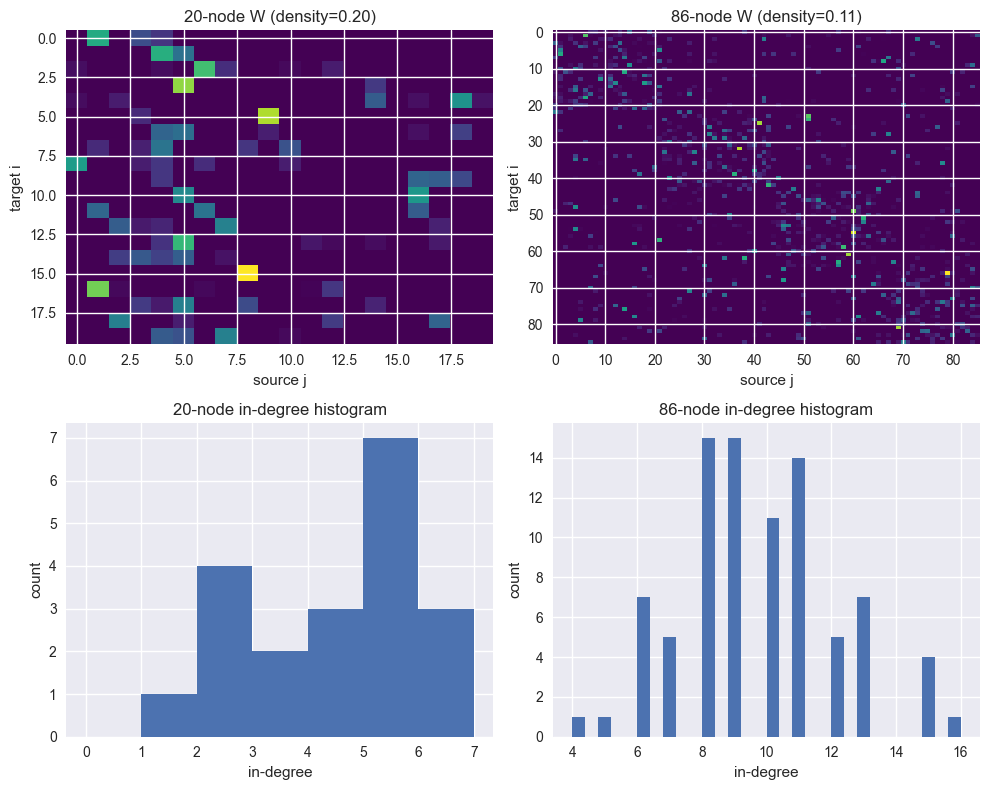

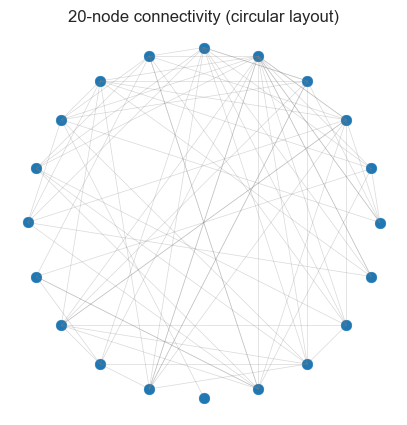

In [33]:
from wendling_sim.connectivity.io import load_connectivity
import matplotlib.pyplot as plt
import numpy as np

conn20 = load_connectivity(net20)
conn86 = load_connectivity(net86)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0,0].imshow(conn20.W, aspect='auto', cmap='viridis')
axes[0,0].set_title(f"20-node W (density={np.mean(conn20.W>0):.2f})")
axes[0,0].set_xlabel('source j'); axes[0,0].set_ylabel('target i')

axes[0,1].imshow(conn86.W, aspect='auto', cmap='viridis')
axes[0,1].set_title(f"86-node W (density={np.mean(conn86.W>0):.2f})")
axes[0,1].set_xlabel('source j'); axes[0,1].set_ylabel('target i')

deg20 = np.sum(conn20.W>0, axis=1)
deg86 = np.sum(conn86.W>0, axis=1)
axes[1,0].hist(deg20, bins=range(0, int(deg20.max())+2))
axes[1,0].set_title('20-node in-degree histogram')
axes[1,0].set_xlabel('in-degree'); axes[1,0].set_ylabel('count')

axes[1,1].hist(deg86, bins=30)
axes[1,1].set_title('86-node in-degree histogram')
axes[1,1].set_xlabel('in-degree'); axes[1,1].set_ylabel('count')

plt.tight_layout(); plt.show()

# Simple circular layout for 20-node graph
pos = np.stack([np.cos(np.linspace(0, 2*np.pi, conn20.n_nodes, endpoint=False)),
                np.sin(np.linspace(0, 2*np.pi, conn20.n_nodes, endpoint=False))], axis=1)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(conn20.n_nodes):
    for j in range(conn20.n_nodes):
        if conn20.W[i, j] > 0:
            ax.plot(pos[[i,j],0], pos[[i,j],1], color='gray', alpha=0.3, linewidth=0.5)
ax.scatter(pos[:,0], pos[:,1], s=60, color='tab:blue')
ax.set_title('20-node connectivity (circular layout)')
ax.axis('off')
plt.show()

## Multi-node activity visualization

Plot several nodes and mean PSD to confirm multi-node dynamics.

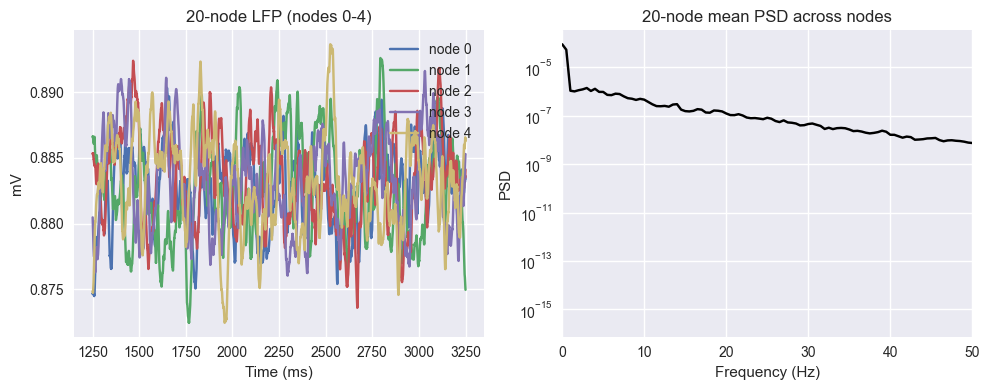

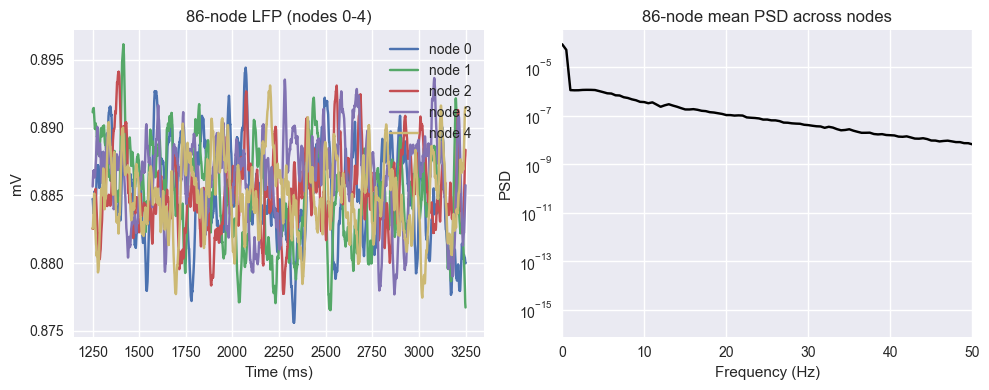

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from wendling_sim.features.psd import compute_psd

def plot_multi_node_activity(res, title, n_plot=5, window_ms=2000):
    lfp = np.asarray(res.lfp)
    t_ms = res.t_s * 1000.0
    n_plot = min(n_plot, lfp.shape[1])
    start = len(t_ms) // 4
    step = int(window_ms / (res.meta['dt_s'] * 1000.0))
    sl = slice(start, min(len(t_ms), start + step))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for k in range(n_plot):
        axes[0].plot(t_ms[sl], lfp[sl, k], label=f'node {k}')
    axes[0].set_title(f"{title} LFP (nodes 0-{n_plot-1})")
    axes[0].set_xlabel('Time (ms)'); axes[0].set_ylabel('mV'); axes[0].legend()

    fs = 1000.0 / (res.meta['dt_s'] * 1000.0)
    psd_res = compute_psd(lfp, fs=fs, roi='none')
    psd_mean = psd_res.psd.mean(axis=1)
    axes[1].semilogy(psd_res.freqs, psd_mean, color='k')
    axes[1].set_xlim(0, 50)
    axes[1].set_title(f"{title} mean PSD across nodes")
    axes[1].set_xlabel('Frequency (Hz)'); axes[1].set_ylabel('PSD')
    plt.tight_layout(); plt.show()

plot_multi_node_activity(res20, '20-node', n_plot=5)
plot_multi_node_activity(res86, '86-node', n_plot=5)
